# Reproduction

## Set-up

Import required packages

In [1]:
# Import model
import model

# Data processing and figure generation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Manage file paths
from dataclasses import dataclass
import os

# Hide warnings that appear
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.filterwarnings('ignore')

# Import and start timer (used to record runtime of this notebook)
import time
start = time.time()

Set file paths

In [2]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    outputs = '../outputs'
    base_5 = 'output_base5.csv'
    base_15 = 'output_base15.csv'
    base_30 = 'output_base30.csv'

    paper = '../../original_study'
    tab2 = 'supp_tab2_reformat.csv'
    tab3 = 'supp_tab3_reformat.csv'
    tab4 = 'supp_tab4_reformat.csv'
    tab5 = 'supp_tab5_reformat.csv'
    tab6 = 'supp_tab6_reformat.csv'


paths = Paths()

## Run model

Base scenario with 15% probability of secondary infection

In [3]:
# Run model
# res = model.run_scenarios()

# Save results to CSV
# res.to_csv(os.path.join(paths.outputs, paths.base_15), index=False)

Base scenario with 5% probability of secondary infection

In [4]:
# Run model
# res = model.run_scenarios(secondary_attack_rate=0.05)

# Save results to CSV
# res.to_csv(os.path.join(paths.outputs, paths.base_5), index=False)

Base scenario with 30% probability of secondary infection

In [5]:
# Run model
# res = model.run_scenarios(secondary_attack_rate=0.3)

# Save results to CSV
# res.to_csv(os.path.join(paths.outputs, paths.base_30), index=False)

## Import results

In [6]:
model_base15 = pd.read_csv(os.path.join(paths.outputs, paths.base_15))
paper_tab2 = pd.read_csv(os.path.join(paths.paper, paths.tab2))

model_tab3 = pd.read_csv(os.path.join(paths.outputs, paths.base_5))
paper_tab3 = pd.read_csv(os.path.join(paths.paper, paths.tab3))

model_tab4 = pd.read_csv(os.path.join(paths.outputs, paths.base_30))
paper_tab4 = pd.read_csv(os.path.join(paths.paper, paths.tab4))

## Function to compare tables

In [7]:
def compare_tables(model_tab, paper_tab):
    '''
    Combine the model and paper tables into single dataframe with a diff column

    Parameters:
    -----------
    model_tab : dataframe
        Raw output from model
    paper_tab : dataframe
        Reformatted table from supplementary materials
    '''
    # Merge the dataframes
    comp = pd.merge(
        model_tab.rename(columns={'prop_infected': 'prop_infected_model'}),
        paper_tab.rename(columns={'prop_infected': 'prop_infected_paper'}))

    # Calculate difference
    comp['diff'] = abs(comp['prop_infected_model'] -
                       comp['prop_infected_paper'])

    return comp

## Examine differences in supplementary tables 2, 3 and 4

Supplementary table 2

In [8]:
# Get table 2 and save to csv
model_tab2 = model_base15[model_base15['end_of_day'].isin([7, 14, 21])]
model_tab2.to_csv(os.path.join(paths.outputs, paths.tab2), index=False)

In [9]:
# Combine model results alongside results from paper
t2_comp = compare_tables(model_tab2, paper_tab2)

# Descriptive statistics for absolute difference in results
print(t2_comp['diff'].describe())

# Extracting instances where absolute difference is more than 0.05
display(t2_comp[t2_comp['diff'] > 0.05])

count    420.000000
mean       0.008571
std        0.016976
min        0.000000
25%        0.000000
50%        0.000000
75%        0.010000
max        0.100000
Name: diff, dtype: float64


,strength,staff_change,staff_per_shift,shifts_per_day,end_of_day,prop_infected_model,prop_infected_paper,diff
24,2,7,5,1,7,0.40,0.30,0.10
96,4,14,5,1,7,0.15,0.20,0.05
97,4,14,5,2,7,0.15,0.20,0.05
98,4,14,5,3,7,0.15,0.20,0.05
110,4,21,5,3,7,0.20,0.15,0.05
180,2,1,5,1,14,0.40,0.30,0.10
204,2,7,5,1,14,0.40,0.30,0.10
243,4,1,10,1,14,0.12,0.17,0.05
247,4,1,20,2,14,0.35,0.41,0.06
254,4,3,5,3,14,0.15,0.20,0.05


Supplementary table 3

In [10]:
# Combine tables
t3_comp = compare_tables(model_tab3, paper_tab3)

# Descriptive statistics for absolute difference in results
print(t3_comp['diff'].describe())

# Extracting instances where absolute difference is more than 0.05
display(t3_comp[t3_comp['diff'] > 0.05])

count    420.000000
mean       0.008738
std        0.014362
min        0.000000
25%        0.000000
50%        0.000000
75%        0.010000
max        0.100000
Name: diff, dtype: float64


,strength,staff_change,staff_per_shift,shifts_per_day,end_of_day,prop_infected_model,prop_infected_paper,diff
30,2,7,20,1,7,0.15,0.2,0.05
36,2,14,5,1,7,0.20,0.1,0.10
210,2,7,20,1,14,0.15,0.2,0.05
384,2,7,5,1,21,0.30,0.2,0.10
470,4,21,5,3,21,0.15,0.2,0.05


Supplementary table 4

In [11]:
# Combine tables
t4_comp = compare_tables(model_tab4, paper_tab4)

# Descriptive statistics for absolute difference in results
print(t4_comp['diff'].describe())

# Extracting instances where absolute difference is more than 0.05
display(t4_comp[t4_comp['diff'] > 0.05])

count    420.000000
mean       0.005333
std        0.013614
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.100000
Name: diff, dtype: float64


,strength,staff_change,staff_per_shift,shifts_per_day,end_of_day,prop_infected_model,prop_infected_paper,diff
12,2,3,5,1,7,0.40,0.30,0.10
67,4,1,20,2,7,0.34,0.26,0.08
72,4,3,5,1,7,0.15,0.20,0.05
74,4,3,5,3,7,0.20,0.15,0.05
242,4,1,5,3,14,0.40,0.30,0.10
244,4,1,10,2,14,0.54,0.60,0.06
307,6,1,20,2,14,0.60,0.54,0.06
421,4,1,5,2,21,0.60,0.65,0.05
483,6,1,10,1,21,0.46,0.41,0.05
484,6,1,10,2,21,0.58,0.51,0.07


## Figure 2

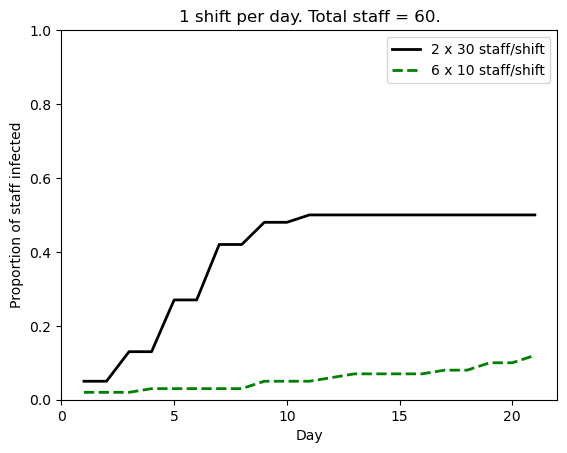

In [12]:
# Line 1 in Figure 2A
fig2a_l1 = model_base15.loc[
    (model_base15['shifts_per_day'] == 1) &
    (model_base15['staff_per_shift'] == 30) &
    (model_base15['strength'] == 2) &
    (model_base15['staff_change']==1), ['end_of_day', 'prop_infected']]
fig2a_l1.set_index('end_of_day', inplace=True)

# Line 2 in Figure 2A
fig2a_l2 = model_base15.loc[
    (model_base15['shifts_per_day'] == 1) &
    (model_base15['staff_per_shift'] == 10) &
    (model_base15['strength'] == 6) &
    (model_base15['staff_change']==1), ['end_of_day', 'prop_infected']]
fig2a_l2.set_index('end_of_day', inplace=True)

plt.plot(fig2a_l1, label='2 x 30 staff/shift', color='black', linewidth=2)
plt.plot(fig2a_l2, label='6 x 10 staff/shift', color='green', linestyle='--', linewidth=2)
plt.xlabel('Day')
plt.xticks(np.arange(0, 21, 5))
plt.ylabel('Proportion of staff infected')
plt.ylim(0, 1)
plt.title('1 shift per day. Total staff = 60.')
plt.legend()
plt.show()

## Time elapsed

In [13]:
# Find run time in seconds
end = time.time()
runtime = round(end-start)

# Display converted to minutes and seconds
print(f'Notebook run time: {runtime//60}m {runtime%60}s')

Notebook run time: 0m 1s
